<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

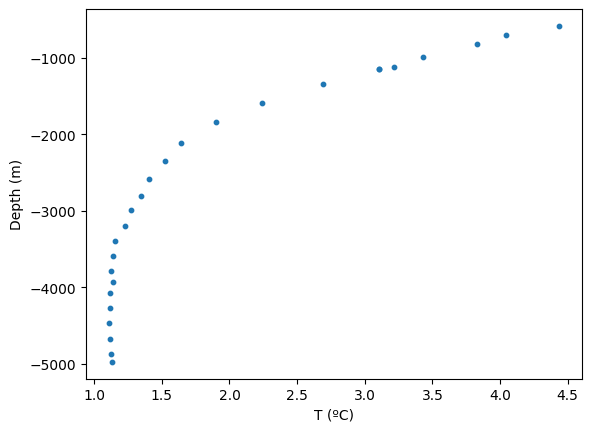

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} \space m/s$, and the diffusivity is set to $10^{-7} \space m^2/s$, to approximate the molecular diffusivity of heat in seawater.

#### Dedalus script

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2024-10-31 14:48:15,311 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


Text(0, 0.5, 'Depth (m)')

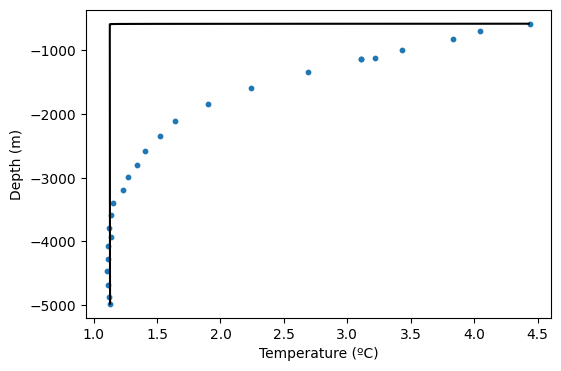

In [4]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-7 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

#### Setting new diffusivity

In [23]:
# Set the diffusivity
kappa=9e-5 # m^2/s

###### Code and plot below

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-10-31 14:57:05,676 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


Text(0, 0.5, 'Depth (m)')

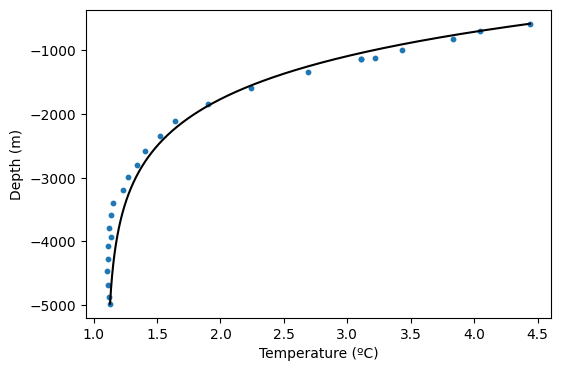

In [24]:
"""
Re-run Dedalus script to solve the steady advection/diffusion equation
"""

logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

##### Discussion

If $\kappa$ is too small, as it was initially, then it suggests all heat remains in the surface ocean, which is not borne out by the observational CTD data. If too big, then the curve fails to fit in the opposite way: it suggests too much heat (relative to the observational reality) is reaching the depths, leaving the shallow waters too cold.

$\kappa = 9 \times 10^{-5} m^2/s$ gives a reasonable fit, and can be thought of as an "effective diffusivity". This is nearly three orders of magnitude greater than the molecular diffusivity, which shows that molecular diffusion of heat is not the dominant form of heat transport. Instead, heat transport appears to be dominated by other factors eg turbulent mixing by eddies.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-10-31 15:54:42,077 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


Text(0, 0.5, 'Depth (m)')

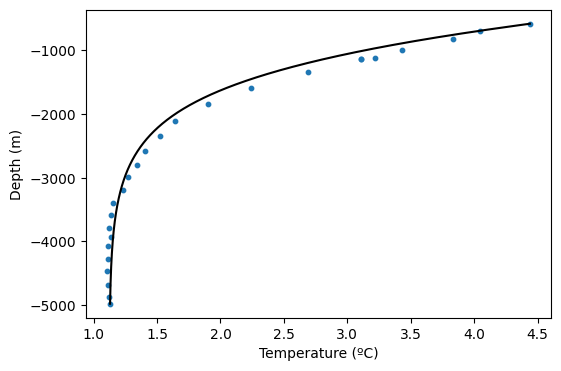

In [49]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity, positive for upwelling
w = 5e-10 # m/s # originally set to zero

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity

# Here are the Rogers et al., 2023 values for characteristic diffusivities
kappa_bg = 1e-5 # m^2/s
kappa_0 = 8.6e-4 # m^2/s
lscale = 667 # m
D = 5000 # m -> reference depth
# Here are alternative values to test their effects (comment out to revert to literature values)
kappa_bg = 1e-5 # m^2/s
kappa_0 = 8.6e-3 # m^2/s
lscale = 667 # m
D = 5000 # m -> reference depth

# Below is the form of the diffusivity profile from Rogers et al., 2023
kappa['g'] = kappa_bg + (kappa_0 - kappa_bg)*np.exp((-D-z)/lscale) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>

a) Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

b) Next, find a vertical velocity that produces a better agreement with the observations and report it below.

c) Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

a) A non-zero vertical velocity is evidently not essential to yield a sensible depth profile. There is still turbulence, but it sums vertically to zero and the eddies are smaller than a grid cell.

b) $z=10^{-8} \space m/s$ is successful as a very slow upwelling, paired with the initial $\kappa(z)$ profile.

c) $\kappa_0$ would be greater with more rough bathymetry, and lower with smaller bathymetry, as there would be fewer internal waves and turbulence across the bottom. With a $\kappa_0$ that is 10x greater, $w$ should be more than 10x smaller (ie the sensitivity of $w$ is greater than 1, but without observational data it is hard to know the real-world consequences of this). This is because rough bathymetry and vertical velocity both cause mixing, so if one is greater, the other should be smaller, in order to yield the same depth profile.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [108]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.5 # maximum current speed in m/s (initially 0.1)
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-10-31 16:49:35,976 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:__main__:Starting main loop


2024-10-31 16:49:35,988 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e-01, dt=3.906250e-01


2024-10-31 16:49:36,049 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e-01, dt=3.906250e-01


INFO:__main__:Iteration=11, Time=4.296875e+00, dt=3.906250e-01


2024-10-31 16:49:36,098 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+00, dt=3.906250e-01


INFO:__main__:Iteration=21, Time=8.203125e+00, dt=3.906250e-01


2024-10-31 16:49:36,146 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+00, dt=3.906250e-01


INFO:__main__:Iteration=31, Time=1.210938e+01, dt=3.906250e-01


2024-10-31 16:49:36,190 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+01, dt=3.906250e-01


INFO:__main__:Iteration=41, Time=1.601562e+01, dt=3.906250e-01


2024-10-31 16:49:36,234 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+01, dt=3.906250e-01


INFO:__main__:Iteration=51, Time=1.992188e+01, dt=3.906250e-01


2024-10-31 16:49:36,282 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+01, dt=3.906250e-01


INFO:__main__:Iteration=61, Time=2.382812e+01, dt=3.906250e-01


2024-10-31 16:49:36,327 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+01, dt=3.906250e-01


INFO:__main__:Iteration=71, Time=2.773438e+01, dt=3.906250e-01


2024-10-31 16:49:36,373 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+01, dt=3.906250e-01


INFO:__main__:Iteration=81, Time=3.164062e+01, dt=3.906250e-01


2024-10-31 16:49:36,425 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+01, dt=3.906250e-01


INFO:__main__:Iteration=91, Time=3.554688e+01, dt=3.906250e-01


2024-10-31 16:49:36,477 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+01, dt=3.906250e-01


INFO:__main__:Iteration=101, Time=3.945312e+01, dt=3.906250e-01


2024-10-31 16:49:36,533 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+01, dt=3.906250e-01


INFO:__main__:Iteration=111, Time=4.335938e+01, dt=3.906250e-01


2024-10-31 16:49:36,586 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+01, dt=3.906250e-01


INFO:__main__:Iteration=121, Time=4.726562e+01, dt=3.906250e-01


2024-10-31 16:49:36,633 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+01, dt=3.906250e-01


INFO:__main__:Iteration=131, Time=5.117188e+01, dt=3.906250e-01


2024-10-31 16:49:36,700 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+01, dt=3.906250e-01


INFO:__main__:Iteration=141, Time=5.507812e+01, dt=3.906250e-01


2024-10-31 16:49:36,765 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+01, dt=3.906250e-01


INFO:__main__:Iteration=151, Time=5.898438e+01, dt=3.906250e-01


2024-10-31 16:49:36,813 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+01, dt=3.906250e-01


INFO:__main__:Iteration=161, Time=6.289062e+01, dt=3.906250e-01


2024-10-31 16:49:36,862 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+01, dt=3.906250e-01


INFO:__main__:Iteration=171, Time=6.679688e+01, dt=3.906250e-01


2024-10-31 16:49:36,907 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+01, dt=3.906250e-01


INFO:__main__:Iteration=181, Time=7.070312e+01, dt=3.906250e-01


2024-10-31 16:49:36,951 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+01, dt=3.906250e-01


INFO:__main__:Iteration=191, Time=7.460938e+01, dt=3.906250e-01


2024-10-31 16:49:36,996 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+01, dt=3.906250e-01


INFO:__main__:Iteration=201, Time=7.851562e+01, dt=3.906250e-01


2024-10-31 16:49:37,042 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+01, dt=3.906250e-01


INFO:__main__:Iteration=211, Time=8.242188e+01, dt=3.906250e-01


2024-10-31 16:49:37,091 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+01, dt=3.906250e-01


INFO:__main__:Iteration=221, Time=8.632812e+01, dt=3.906250e-01


2024-10-31 16:49:37,138 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+01, dt=3.906250e-01


INFO:__main__:Iteration=231, Time=9.023438e+01, dt=3.906250e-01


2024-10-31 16:49:37,183 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+01, dt=3.906250e-01


INFO:__main__:Iteration=241, Time=9.414062e+01, dt=3.906250e-01


2024-10-31 16:49:37,230 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+01, dt=3.906250e-01


INFO:__main__:Iteration=251, Time=9.804688e+01, dt=3.906250e-01


2024-10-31 16:49:37,278 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+01, dt=3.906250e-01


INFO:__main__:Iteration=261, Time=1.019531e+02, dt=3.906250e-01


2024-10-31 16:49:37,315 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=271, Time=1.058594e+02, dt=3.906250e-01


2024-10-31 16:49:37,347 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=281, Time=1.097656e+02, dt=3.906250e-01


2024-10-31 16:49:37,379 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=291, Time=1.136719e+02, dt=3.906250e-01


2024-10-31 16:49:37,411 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=301, Time=1.175781e+02, dt=3.906250e-01


2024-10-31 16:49:37,443 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=311, Time=1.214844e+02, dt=3.906250e-01


2024-10-31 16:49:37,476 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=321, Time=1.253906e+02, dt=3.906250e-01


2024-10-31 16:49:37,511 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=331, Time=1.292969e+02, dt=3.906250e-01


2024-10-31 16:49:37,553 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=341, Time=1.332031e+02, dt=3.906250e-01


2024-10-31 16:49:37,592 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=351, Time=1.371094e+02, dt=3.906250e-01


2024-10-31 16:49:37,632 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=361, Time=1.410156e+02, dt=3.906250e-01


2024-10-31 16:49:37,671 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=371, Time=1.449219e+02, dt=3.906250e-01


2024-10-31 16:49:37,712 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=381, Time=1.488281e+02, dt=3.906250e-01


2024-10-31 16:49:37,754 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=391, Time=1.527344e+02, dt=3.906250e-01


2024-10-31 16:49:37,802 __main__ 0/1 INFO :: Iteration=391, Time=1.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=401, Time=1.566406e+02, dt=3.906250e-01


2024-10-31 16:49:37,845 __main__ 0/1 INFO :: Iteration=401, Time=1.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=411, Time=1.605469e+02, dt=3.906250e-01


2024-10-31 16:49:37,880 __main__ 0/1 INFO :: Iteration=411, Time=1.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=421, Time=1.644531e+02, dt=3.906250e-01


2024-10-31 16:49:37,913 __main__ 0/1 INFO :: Iteration=421, Time=1.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=431, Time=1.683594e+02, dt=3.906250e-01


2024-10-31 16:49:37,944 __main__ 0/1 INFO :: Iteration=431, Time=1.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=441, Time=1.722656e+02, dt=3.906250e-01


2024-10-31 16:49:37,975 __main__ 0/1 INFO :: Iteration=441, Time=1.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=451, Time=1.761719e+02, dt=3.906250e-01


2024-10-31 16:49:38,006 __main__ 0/1 INFO :: Iteration=451, Time=1.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=461, Time=1.800781e+02, dt=3.906250e-01


2024-10-31 16:49:38,036 __main__ 0/1 INFO :: Iteration=461, Time=1.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=471, Time=1.839844e+02, dt=3.906250e-01


2024-10-31 16:49:38,073 __main__ 0/1 INFO :: Iteration=471, Time=1.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=481, Time=1.878906e+02, dt=3.906250e-01


2024-10-31 16:49:38,107 __main__ 0/1 INFO :: Iteration=481, Time=1.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=491, Time=1.917969e+02, dt=3.906250e-01


2024-10-31 16:49:38,140 __main__ 0/1 INFO :: Iteration=491, Time=1.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=501, Time=1.957031e+02, dt=3.906250e-01


2024-10-31 16:49:38,175 __main__ 0/1 INFO :: Iteration=501, Time=1.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=511, Time=1.996094e+02, dt=3.906250e-01


2024-10-31 16:49:38,209 __main__ 0/1 INFO :: Iteration=511, Time=1.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=521, Time=2.035156e+02, dt=3.906250e-01


2024-10-31 16:49:38,243 __main__ 0/1 INFO :: Iteration=521, Time=2.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=531, Time=2.074219e+02, dt=3.906250e-01


2024-10-31 16:49:38,278 __main__ 0/1 INFO :: Iteration=531, Time=2.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=541, Time=2.113281e+02, dt=3.906250e-01


2024-10-31 16:49:38,309 __main__ 0/1 INFO :: Iteration=541, Time=2.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=551, Time=2.152344e+02, dt=3.906250e-01


2024-10-31 16:49:38,340 __main__ 0/1 INFO :: Iteration=551, Time=2.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=561, Time=2.191406e+02, dt=3.906250e-01


2024-10-31 16:49:38,372 __main__ 0/1 INFO :: Iteration=561, Time=2.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=571, Time=2.230469e+02, dt=3.906250e-01


2024-10-31 16:49:38,404 __main__ 0/1 INFO :: Iteration=571, Time=2.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=581, Time=2.269531e+02, dt=3.906250e-01


2024-10-31 16:49:38,438 __main__ 0/1 INFO :: Iteration=581, Time=2.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=591, Time=2.308594e+02, dt=3.906250e-01


2024-10-31 16:49:38,472 __main__ 0/1 INFO :: Iteration=591, Time=2.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=601, Time=2.347656e+02, dt=3.906250e-01


2024-10-31 16:49:38,511 __main__ 0/1 INFO :: Iteration=601, Time=2.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=611, Time=2.386719e+02, dt=3.906250e-01


2024-10-31 16:49:38,554 __main__ 0/1 INFO :: Iteration=611, Time=2.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=621, Time=2.425781e+02, dt=3.906250e-01


2024-10-31 16:49:38,596 __main__ 0/1 INFO :: Iteration=621, Time=2.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=631, Time=2.464844e+02, dt=3.906250e-01


2024-10-31 16:49:38,636 __main__ 0/1 INFO :: Iteration=631, Time=2.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=641, Time=2.503906e+02, dt=3.906250e-01


2024-10-31 16:49:38,679 __main__ 0/1 INFO :: Iteration=641, Time=2.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=651, Time=2.542969e+02, dt=3.906250e-01


2024-10-31 16:49:38,725 __main__ 0/1 INFO :: Iteration=651, Time=2.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=661, Time=2.582031e+02, dt=3.906250e-01


2024-10-31 16:49:38,766 __main__ 0/1 INFO :: Iteration=661, Time=2.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=671, Time=2.621094e+02, dt=3.906250e-01


2024-10-31 16:49:38,809 __main__ 0/1 INFO :: Iteration=671, Time=2.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=681, Time=2.660156e+02, dt=3.906250e-01


2024-10-31 16:49:38,856 __main__ 0/1 INFO :: Iteration=681, Time=2.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=691, Time=2.699219e+02, dt=3.906250e-01


2024-10-31 16:49:38,889 __main__ 0/1 INFO :: Iteration=691, Time=2.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=701, Time=2.738281e+02, dt=3.906250e-01


2024-10-31 16:49:38,923 __main__ 0/1 INFO :: Iteration=701, Time=2.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=711, Time=2.777344e+02, dt=3.906250e-01


2024-10-31 16:49:38,956 __main__ 0/1 INFO :: Iteration=711, Time=2.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=721, Time=2.816406e+02, dt=3.906250e-01


2024-10-31 16:49:38,989 __main__ 0/1 INFO :: Iteration=721, Time=2.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=731, Time=2.855469e+02, dt=3.906250e-01


2024-10-31 16:49:39,021 __main__ 0/1 INFO :: Iteration=731, Time=2.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=741, Time=2.894531e+02, dt=3.906250e-01


2024-10-31 16:49:39,053 __main__ 0/1 INFO :: Iteration=741, Time=2.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=751, Time=2.933594e+02, dt=3.906250e-01


2024-10-31 16:49:39,088 __main__ 0/1 INFO :: Iteration=751, Time=2.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=761, Time=2.972656e+02, dt=3.906250e-01


2024-10-31 16:49:39,122 __main__ 0/1 INFO :: Iteration=761, Time=2.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=771, Time=3.011719e+02, dt=3.906250e-01


2024-10-31 16:49:39,154 __main__ 0/1 INFO :: Iteration=771, Time=3.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=781, Time=3.050781e+02, dt=3.906250e-01


2024-10-31 16:49:39,186 __main__ 0/1 INFO :: Iteration=781, Time=3.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=791, Time=3.089844e+02, dt=3.906250e-01


2024-10-31 16:49:39,219 __main__ 0/1 INFO :: Iteration=791, Time=3.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=801, Time=3.128906e+02, dt=3.906250e-01


2024-10-31 16:49:39,256 __main__ 0/1 INFO :: Iteration=801, Time=3.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=811, Time=3.167969e+02, dt=3.906250e-01


2024-10-31 16:49:39,289 __main__ 0/1 INFO :: Iteration=811, Time=3.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=821, Time=3.207031e+02, dt=3.906250e-01


2024-10-31 16:49:39,321 __main__ 0/1 INFO :: Iteration=821, Time=3.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=831, Time=3.246094e+02, dt=3.906250e-01


2024-10-31 16:49:39,352 __main__ 0/1 INFO :: Iteration=831, Time=3.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=841, Time=3.285156e+02, dt=3.906250e-01


2024-10-31 16:49:39,384 __main__ 0/1 INFO :: Iteration=841, Time=3.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=851, Time=3.324219e+02, dt=3.906250e-01


2024-10-31 16:49:39,417 __main__ 0/1 INFO :: Iteration=851, Time=3.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=861, Time=3.363281e+02, dt=3.906250e-01


2024-10-31 16:49:39,448 __main__ 0/1 INFO :: Iteration=861, Time=3.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=871, Time=3.402344e+02, dt=3.906250e-01


2024-10-31 16:49:39,481 __main__ 0/1 INFO :: Iteration=871, Time=3.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=881, Time=3.441406e+02, dt=3.906250e-01


2024-10-31 16:49:39,519 __main__ 0/1 INFO :: Iteration=881, Time=3.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=891, Time=3.480469e+02, dt=3.906250e-01


2024-10-31 16:49:39,566 __main__ 0/1 INFO :: Iteration=891, Time=3.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=901, Time=3.519531e+02, dt=3.906250e-01


2024-10-31 16:49:39,609 __main__ 0/1 INFO :: Iteration=901, Time=3.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=911, Time=3.558594e+02, dt=3.906250e-01


2024-10-31 16:49:39,650 __main__ 0/1 INFO :: Iteration=911, Time=3.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=921, Time=3.597656e+02, dt=3.906250e-01


2024-10-31 16:49:39,695 __main__ 0/1 INFO :: Iteration=921, Time=3.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=931, Time=3.636719e+02, dt=3.906250e-01


2024-10-31 16:49:39,740 __main__ 0/1 INFO :: Iteration=931, Time=3.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=941, Time=3.675781e+02, dt=3.906250e-01


2024-10-31 16:49:39,783 __main__ 0/1 INFO :: Iteration=941, Time=3.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=951, Time=3.714844e+02, dt=3.906250e-01


2024-10-31 16:49:39,832 __main__ 0/1 INFO :: Iteration=951, Time=3.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=961, Time=3.753906e+02, dt=3.906250e-01


2024-10-31 16:49:39,875 __main__ 0/1 INFO :: Iteration=961, Time=3.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=971, Time=3.792969e+02, dt=3.906250e-01


2024-10-31 16:49:39,915 __main__ 0/1 INFO :: Iteration=971, Time=3.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=981, Time=3.832031e+02, dt=3.906250e-01


2024-10-31 16:49:39,948 __main__ 0/1 INFO :: Iteration=981, Time=3.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=991, Time=3.871094e+02, dt=3.906250e-01


2024-10-31 16:49:39,981 __main__ 0/1 INFO :: Iteration=991, Time=3.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


2024-10-31 16:49:40,016 __main__ 0/1 INFO :: Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


2024-10-31 16:49:40,049 __main__ 0/1 INFO :: Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


2024-10-31 16:49:40,085 __main__ 0/1 INFO :: Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


2024-10-31 16:49:40,120 __main__ 0/1 INFO :: Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


2024-10-31 16:49:40,154 __main__ 0/1 INFO :: Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


2024-10-31 16:49:40,193 __main__ 0/1 INFO :: Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


2024-10-31 16:49:40,228 __main__ 0/1 INFO :: Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


2024-10-31 16:49:40,262 __main__ 0/1 INFO :: Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


2024-10-31 16:49:40,296 __main__ 0/1 INFO :: Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


2024-10-31 16:49:40,332 __main__ 0/1 INFO :: Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


2024-10-31 16:49:40,368 __main__ 0/1 INFO :: Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


2024-10-31 16:49:40,403 __main__ 0/1 INFO :: Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


2024-10-31 16:49:40,438 __main__ 0/1 INFO :: Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


2024-10-31 16:49:40,473 __main__ 0/1 INFO :: Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


2024-10-31 16:49:40,515 __main__ 0/1 INFO :: Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


2024-10-31 16:49:40,561 __main__ 0/1 INFO :: Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


2024-10-31 16:49:40,607 __main__ 0/1 INFO :: Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


2024-10-31 16:49:40,653 __main__ 0/1 INFO :: Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


2024-10-31 16:49:40,695 __main__ 0/1 INFO :: Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


2024-10-31 16:49:40,740 __main__ 0/1 INFO :: Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


2024-10-31 16:49:40,786 __main__ 0/1 INFO :: Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


2024-10-31 16:49:40,830 __main__ 0/1 INFO :: Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


2024-10-31 16:49:40,864 __main__ 0/1 INFO :: Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


2024-10-31 16:49:40,900 __main__ 0/1 INFO :: Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


2024-10-31 16:49:40,943 __main__ 0/1 INFO :: Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


2024-10-31 16:49:40,976 __main__ 0/1 INFO :: Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


2024-10-31 16:49:41,012 __main__ 0/1 INFO :: Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


2024-10-31 16:49:41,046 __main__ 0/1 INFO :: Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


2024-10-31 16:49:41,083 __main__ 0/1 INFO :: Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


2024-10-31 16:49:41,122 __main__ 0/1 INFO :: Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


2024-10-31 16:49:41,158 __main__ 0/1 INFO :: Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


2024-10-31 16:49:41,193 __main__ 0/1 INFO :: Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


2024-10-31 16:49:41,227 __main__ 0/1 INFO :: Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


2024-10-31 16:49:41,262 __main__ 0/1 INFO :: Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


2024-10-31 16:49:41,296 __main__ 0/1 INFO :: Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


2024-10-31 16:49:41,329 __main__ 0/1 INFO :: Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


2024-10-31 16:49:41,361 __main__ 0/1 INFO :: Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


2024-10-31 16:49:41,394 __main__ 0/1 INFO :: Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


2024-10-31 16:49:41,427 __main__ 0/1 INFO :: Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


2024-10-31 16:49:41,466 __main__ 0/1 INFO :: Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


2024-10-31 16:49:41,506 __main__ 0/1 INFO :: Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


2024-10-31 16:49:41,547 __main__ 0/1 INFO :: Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


2024-10-31 16:49:41,591 __main__ 0/1 INFO :: Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


2024-10-31 16:49:41,637 __main__ 0/1 INFO :: Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


2024-10-31 16:49:41,678 __main__ 0/1 INFO :: Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


2024-10-31 16:49:41,722 __main__ 0/1 INFO :: Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


2024-10-31 16:49:41,769 __main__ 0/1 INFO :: Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


2024-10-31 16:49:41,814 __main__ 0/1 INFO :: Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


2024-10-31 16:49:41,857 __main__ 0/1 INFO :: Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


2024-10-31 16:49:41,891 __main__ 0/1 INFO :: Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


2024-10-31 16:49:41,930 __main__ 0/1 INFO :: Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


2024-10-31 16:49:41,977 __main__ 0/1 INFO :: Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


2024-10-31 16:49:42,013 __main__ 0/1 INFO :: Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


2024-10-31 16:49:42,045 __main__ 0/1 INFO :: Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


2024-10-31 16:49:42,080 __main__ 0/1 INFO :: Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


2024-10-31 16:49:42,113 __main__ 0/1 INFO :: Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


2024-10-31 16:49:42,147 __main__ 0/1 INFO :: Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


2024-10-31 16:49:42,182 __main__ 0/1 INFO :: Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


2024-10-31 16:49:42,215 __main__ 0/1 INFO :: Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


2024-10-31 16:49:42,248 __main__ 0/1 INFO :: Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


2024-10-31 16:49:42,288 __main__ 0/1 INFO :: Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


2024-10-31 16:49:42,323 __main__ 0/1 INFO :: Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


2024-10-31 16:49:42,357 __main__ 0/1 INFO :: Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


2024-10-31 16:49:42,393 __main__ 0/1 INFO :: Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


2024-10-31 16:49:42,429 __main__ 0/1 INFO :: Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


2024-10-31 16:49:42,463 __main__ 0/1 INFO :: Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


2024-10-31 16:49:42,502 __main__ 0/1 INFO :: Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


2024-10-31 16:49:42,546 __main__ 0/1 INFO :: Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


2024-10-31 16:49:42,593 __main__ 0/1 INFO :: Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


2024-10-31 16:49:42,633 __main__ 0/1 INFO :: Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


2024-10-31 16:49:42,682 __main__ 0/1 INFO :: Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


2024-10-31 16:49:42,724 __main__ 0/1 INFO :: Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


2024-10-31 16:49:42,770 __main__ 0/1 INFO :: Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


2024-10-31 16:49:42,813 __main__ 0/1 INFO :: Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


2024-10-31 16:49:42,854 __main__ 0/1 INFO :: Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


2024-10-31 16:49:42,887 __main__ 0/1 INFO :: Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


2024-10-31 16:49:42,920 __main__ 0/1 INFO :: Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


2024-10-31 16:49:42,955 __main__ 0/1 INFO :: Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


2024-10-31 16:49:43,000 __main__ 0/1 INFO :: Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


2024-10-31 16:49:43,033 __main__ 0/1 INFO :: Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


2024-10-31 16:49:43,074 __main__ 0/1 INFO :: Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


2024-10-31 16:49:43,107 __main__ 0/1 INFO :: Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


2024-10-31 16:49:43,143 __main__ 0/1 INFO :: Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


2024-10-31 16:49:43,175 __main__ 0/1 INFO :: Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


2024-10-31 16:49:43,208 __main__ 0/1 INFO :: Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


2024-10-31 16:49:43,243 __main__ 0/1 INFO :: Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


2024-10-31 16:49:43,277 __main__ 0/1 INFO :: Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


2024-10-31 16:49:43,311 __main__ 0/1 INFO :: Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


2024-10-31 16:49:43,345 __main__ 0/1 INFO :: Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


2024-10-31 16:49:43,381 __main__ 0/1 INFO :: Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


2024-10-31 16:49:43,415 __main__ 0/1 INFO :: Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


2024-10-31 16:49:43,454 __main__ 0/1 INFO :: Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


2024-10-31 16:49:43,490 __main__ 0/1 INFO :: Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


2024-10-31 16:49:43,533 __main__ 0/1 INFO :: Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


2024-10-31 16:49:43,574 __main__ 0/1 INFO :: Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


2024-10-31 16:49:43,618 __main__ 0/1 INFO :: Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


2024-10-31 16:49:43,663 __main__ 0/1 INFO :: Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


2024-10-31 16:49:43,709 __main__ 0/1 INFO :: Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


2024-10-31 16:49:43,750 __main__ 0/1 INFO :: Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


2024-10-31 16:49:43,796 __main__ 0/1 INFO :: Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


2024-10-31 16:49:43,835 __main__ 0/1 INFO :: Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


2024-10-31 16:49:43,870 __main__ 0/1 INFO :: Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


2024-10-31 16:49:43,903 __main__ 0/1 INFO :: Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


2024-10-31 16:49:43,935 __main__ 0/1 INFO :: Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


2024-10-31 16:49:43,968 __main__ 0/1 INFO :: Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


2024-10-31 16:49:44,004 __main__ 0/1 INFO :: Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


2024-10-31 16:49:44,046 __main__ 0/1 INFO :: Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


2024-10-31 16:49:44,081 __main__ 0/1 INFO :: Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


2024-10-31 16:49:44,115 __main__ 0/1 INFO :: Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


2024-10-31 16:49:44,155 __main__ 0/1 INFO :: Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


2024-10-31 16:49:44,190 __main__ 0/1 INFO :: Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


2024-10-31 16:49:44,224 __main__ 0/1 INFO :: Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


2024-10-31 16:49:44,260 __main__ 0/1 INFO :: Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


2024-10-31 16:49:44,297 __main__ 0/1 INFO :: Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


2024-10-31 16:49:44,334 __main__ 0/1 INFO :: Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


2024-10-31 16:49:44,373 __main__ 0/1 INFO :: Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


2024-10-31 16:49:44,410 __main__ 0/1 INFO :: Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


2024-10-31 16:49:44,448 __main__ 0/1 INFO :: Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


2024-10-31 16:49:44,485 __main__ 0/1 INFO :: Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


2024-10-31 16:49:44,532 __main__ 0/1 INFO :: Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


2024-10-31 16:49:44,587 __main__ 0/1 INFO :: Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


2024-10-31 16:49:44,636 __main__ 0/1 INFO :: Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


2024-10-31 16:49:44,680 __main__ 0/1 INFO :: Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


2024-10-31 16:49:44,725 __main__ 0/1 INFO :: Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


2024-10-31 16:49:44,771 __main__ 0/1 INFO :: Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


2024-10-31 16:49:44,821 __main__ 0/1 INFO :: Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


2024-10-31 16:49:44,869 __main__ 0/1 INFO :: Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


2024-10-31 16:49:44,905 __main__ 0/1 INFO :: Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


2024-10-31 16:49:44,942 __main__ 0/1 INFO :: Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


2024-10-31 16:49:44,979 __main__ 0/1 INFO :: Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


2024-10-31 16:49:45,022 __main__ 0/1 INFO :: Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


2024-10-31 16:49:45,071 __main__ 0/1 INFO :: Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


2024-10-31 16:49:45,111 __main__ 0/1 INFO :: Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


2024-10-31 16:49:45,156 __main__ 0/1 INFO :: Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


2024-10-31 16:49:45,192 __main__ 0/1 INFO :: Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


2024-10-31 16:49:45,226 __main__ 0/1 INFO :: Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


2024-10-31 16:49:45,261 __main__ 0/1 INFO :: Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


2024-10-31 16:49:45,298 __main__ 0/1 INFO :: Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


2024-10-31 16:49:45,332 __main__ 0/1 INFO :: Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


2024-10-31 16:49:45,370 __main__ 0/1 INFO :: Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


2024-10-31 16:49:45,411 __main__ 0/1 INFO :: Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


2024-10-31 16:49:45,445 __main__ 0/1 INFO :: Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


2024-10-31 16:49:45,480 __main__ 0/1 INFO :: Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


2024-10-31 16:49:45,527 __main__ 0/1 INFO :: Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


2024-10-31 16:49:45,575 __main__ 0/1 INFO :: Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


2024-10-31 16:49:45,619 __main__ 0/1 INFO :: Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


2024-10-31 16:49:45,664 __main__ 0/1 INFO :: Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


2024-10-31 16:49:45,712 __main__ 0/1 INFO :: Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


2024-10-31 16:49:45,763 __main__ 0/1 INFO :: Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


2024-10-31 16:49:45,808 __main__ 0/1 INFO :: Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


2024-10-31 16:49:45,849 __main__ 0/1 INFO :: Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


2024-10-31 16:49:45,884 __main__ 0/1 INFO :: Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


2024-10-31 16:49:45,921 __main__ 0/1 INFO :: Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


2024-10-31 16:49:45,958 __main__ 0/1 INFO :: Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


2024-10-31 16:49:45,997 __main__ 0/1 INFO :: Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


2024-10-31 16:49:46,032 __main__ 0/1 INFO :: Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


2024-10-31 16:49:46,071 __main__ 0/1 INFO :: Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


2024-10-31 16:49:46,121 __main__ 0/1 INFO :: Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


2024-10-31 16:49:46,158 __main__ 0/1 INFO :: Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


2024-10-31 16:49:46,193 __main__ 0/1 INFO :: Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


2024-10-31 16:49:46,230 __main__ 0/1 INFO :: Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


2024-10-31 16:49:46,265 __main__ 0/1 INFO :: Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


2024-10-31 16:49:46,301 __main__ 0/1 INFO :: Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


2024-10-31 16:49:46,337 __main__ 0/1 INFO :: Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


2024-10-31 16:49:46,372 __main__ 0/1 INFO :: Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


2024-10-31 16:49:46,408 __main__ 0/1 INFO :: Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


2024-10-31 16:49:46,451 __main__ 0/1 INFO :: Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


2024-10-31 16:49:46,488 __main__ 0/1 INFO :: Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


INFO:__main__:Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


2024-10-31 16:49:46,532 __main__ 0/1 INFO :: Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


INFO:__main__:Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


2024-10-31 16:49:46,577 __main__ 0/1 INFO :: Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


INFO:__main__:Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


2024-10-31 16:49:46,624 __main__ 0/1 INFO :: Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


INFO:__main__:Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


2024-10-31 16:49:46,670 __main__ 0/1 INFO :: Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


INFO:__main__:Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


2024-10-31 16:49:46,710 __main__ 0/1 INFO :: Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


INFO:__main__:Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


2024-10-31 16:49:46,753 __main__ 0/1 INFO :: Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


INFO:__main__:Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


2024-10-31 16:49:46,799 __main__ 0/1 INFO :: Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


INFO:__main__:Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


2024-10-31 16:49:46,842 __main__ 0/1 INFO :: Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


INFO:__main__:Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


2024-10-31 16:49:46,880 __main__ 0/1 INFO :: Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


INFO:__main__:Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


2024-10-31 16:49:46,916 __main__ 0/1 INFO :: Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


INFO:__main__:Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


2024-10-31 16:49:46,951 __main__ 0/1 INFO :: Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


INFO:__main__:Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


2024-10-31 16:49:46,985 __main__ 0/1 INFO :: Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


INFO:__main__:Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


2024-10-31 16:49:47,023 __main__ 0/1 INFO :: Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


INFO:__main__:Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


2024-10-31 16:49:47,061 __main__ 0/1 INFO :: Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


INFO:__main__:Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


2024-10-31 16:49:47,101 __main__ 0/1 INFO :: Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


INFO:__main__:Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


2024-10-31 16:49:47,151 __main__ 0/1 INFO :: Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


INFO:__main__:Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


2024-10-31 16:49:47,191 __main__ 0/1 INFO :: Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


INFO:__main__:Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


2024-10-31 16:49:47,227 __main__ 0/1 INFO :: Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


INFO:__main__:Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


2024-10-31 16:49:47,261 __main__ 0/1 INFO :: Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


INFO:__main__:Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


2024-10-31 16:49:47,298 __main__ 0/1 INFO :: Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


INFO:__main__:Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


2024-10-31 16:49:47,357 __main__ 0/1 INFO :: Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


2024-10-31 16:49:47,404 __main__ 0/1 INFO :: Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


2024-10-31 16:49:47,453 __main__ 0/1 INFO :: Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


2024-10-31 16:49:47,503 __main__ 0/1 INFO :: Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


2024-10-31 16:49:47,555 __main__ 0/1 INFO :: Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


2024-10-31 16:49:47,610 __main__ 0/1 INFO :: Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


2024-10-31 16:49:47,664 __main__ 0/1 INFO :: Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


2024-10-31 16:49:47,718 __main__ 0/1 INFO :: Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


2024-10-31 16:49:47,774 __main__ 0/1 INFO :: Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


2024-10-31 16:49:47,829 __main__ 0/1 INFO :: Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


2024-10-31 16:49:47,885 __main__ 0/1 INFO :: Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


2024-10-31 16:49:47,935 __main__ 0/1 INFO :: Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


2024-10-31 16:49:47,984 __main__ 0/1 INFO :: Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


2024-10-31 16:49:48,032 __main__ 0/1 INFO :: Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


2024-10-31 16:49:48,086 __main__ 0/1 INFO :: Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


2024-10-31 16:49:48,138 __main__ 0/1 INFO :: Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


2024-10-31 16:49:48,188 __main__ 0/1 INFO :: Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


2024-10-31 16:49:48,251 __main__ 0/1 INFO :: Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


2024-10-31 16:49:48,298 __main__ 0/1 INFO :: Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


2024-10-31 16:49:48,344 __main__ 0/1 INFO :: Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


2024-10-31 16:49:48,387 __main__ 0/1 INFO :: Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


2024-10-31 16:49:48,437 __main__ 0/1 INFO :: Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


2024-10-31 16:49:48,485 __main__ 0/1 INFO :: Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


2024-10-31 16:49:48,541 __main__ 0/1 INFO :: Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


2024-10-31 16:49:48,607 __main__ 0/1 INFO :: Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


2024-10-31 16:49:48,668 __main__ 0/1 INFO :: Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


2024-10-31 16:49:48,726 __main__ 0/1 INFO :: Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


2024-10-31 16:49:48,773 __main__ 0/1 INFO :: Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


2024-10-31 16:49:48,818 __main__ 0/1 INFO :: Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


2024-10-31 16:49:48,860 __main__ 0/1 INFO :: Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


2024-10-31 16:49:48,903 __main__ 0/1 INFO :: Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


2024-10-31 16:49:48,947 __main__ 0/1 INFO :: Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


2024-10-31 16:49:48,995 __main__ 0/1 INFO :: Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


2024-10-31 16:49:49,045 __main__ 0/1 INFO :: Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


2024-10-31 16:49:49,095 __main__ 0/1 INFO :: Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


2024-10-31 16:49:49,138 __main__ 0/1 INFO :: Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


2024-10-31 16:49:49,181 __main__ 0/1 INFO :: Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


2024-10-31 16:49:49,227 __main__ 0/1 INFO :: Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


2024-10-31 16:49:49,270 __main__ 0/1 INFO :: Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


2024-10-31 16:49:49,324 __main__ 0/1 INFO :: Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


2024-10-31 16:49:49,375 __main__ 0/1 INFO :: Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


2024-10-31 16:49:49,417 __main__ 0/1 INFO :: Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


2024-10-31 16:49:49,460 __main__ 0/1 INFO :: Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


2024-10-31 16:49:49,504 __main__ 0/1 INFO :: Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


2024-10-31 16:49:49,546 __main__ 0/1 INFO :: Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


2024-10-31 16:49:49,608 __main__ 0/1 INFO :: Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


2024-10-31 16:49:49,682 __main__ 0/1 INFO :: Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


2024-10-31 16:49:49,742 __main__ 0/1 INFO :: Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


2024-10-31 16:49:49,800 __main__ 0/1 INFO :: Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


2024-10-31 16:49:49,851 __main__ 0/1 INFO :: Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


2024-10-31 16:49:49,908 __main__ 0/1 INFO :: Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


2024-10-31 16:49:49,954 __main__ 0/1 INFO :: Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


2024-10-31 16:49:50,001 __main__ 0/1 INFO :: Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


2024-10-31 16:49:50,048 __main__ 0/1 INFO :: Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


2024-10-31 16:49:50,096 __main__ 0/1 INFO :: Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


2024-10-31 16:49:50,160 __main__ 0/1 INFO :: Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


2024-10-31 16:49:50,212 __main__ 0/1 INFO :: Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


2024-10-31 16:49:50,266 __main__ 0/1 INFO :: Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


2024-10-31 16:49:50,314 __main__ 0/1 INFO :: Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


2024-10-31 16:49:50,367 __main__ 0/1 INFO :: Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


2024-10-31 16:49:50,424 __main__ 0/1 INFO :: Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


2024-10-31 16:49:50,470 __main__ 0/1 INFO :: Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


2024-10-31 16:49:50,519 __main__ 0/1 INFO :: Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


2024-10-31 16:49:50,580 __main__ 0/1 INFO :: Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


2024-10-31 16:49:50,636 __main__ 0/1 INFO :: Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


2024-10-31 16:49:50,692 __main__ 0/1 INFO :: Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


2024-10-31 16:49:50,754 __main__ 0/1 INFO :: Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


2024-10-31 16:49:50,803 __main__ 0/1 INFO :: Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


2024-10-31 16:49:50,855 __main__ 0/1 INFO :: Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


2024-10-31 16:49:50,903 __main__ 0/1 INFO :: Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


2024-10-31 16:49:50,949 __main__ 0/1 INFO :: Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


2024-10-31 16:49:50,994 __main__ 0/1 INFO :: Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


2024-10-31 16:49:51,041 __main__ 0/1 INFO :: Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


2024-10-31 16:49:51,098 __main__ 0/1 INFO :: Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


2024-10-31 16:49:51,154 __main__ 0/1 INFO :: Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


2024-10-31 16:49:51,209 __main__ 0/1 INFO :: Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


2024-10-31 16:49:51,257 __main__ 0/1 INFO :: Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


2024-10-31 16:49:51,305 __main__ 0/1 INFO :: Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


2024-10-31 16:49:51,354 __main__ 0/1 INFO :: Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


2024-10-31 16:49:51,403 __main__ 0/1 INFO :: Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


2024-10-31 16:49:51,460 __main__ 0/1 INFO :: Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


2024-10-31 16:49:51,517 __main__ 0/1 INFO :: Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


2024-10-31 16:49:51,584 __main__ 0/1 INFO :: Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


2024-10-31 16:49:51,654 __main__ 0/1 INFO :: Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


2024-10-31 16:49:51,718 __main__ 0/1 INFO :: Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


2024-10-31 16:49:51,776 __main__ 0/1 INFO :: Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


2024-10-31 16:49:51,824 __main__ 0/1 INFO :: Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


2024-10-31 16:49:51,868 __main__ 0/1 INFO :: Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


2024-10-31 16:49:51,912 __main__ 0/1 INFO :: Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


2024-10-31 16:49:51,963 __main__ 0/1 INFO :: Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


2024-10-31 16:49:52,011 __main__ 0/1 INFO :: Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


2024-10-31 16:49:52,054 __main__ 0/1 INFO :: Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


2024-10-31 16:49:52,102 __main__ 0/1 INFO :: Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


2024-10-31 16:49:52,145 __main__ 0/1 INFO :: Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


2024-10-31 16:49:52,190 __main__ 0/1 INFO :: Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


2024-10-31 16:49:52,233 __main__ 0/1 INFO :: Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


INFO:solvers:Simulation stop time reached.


2024-10-31 16:49:52,273 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 3840


2024-10-31 16:49:52,277 solvers 0/1 INFO :: Final iteration: 3840


INFO:solvers:Final sim time: 1500.0


2024-10-31 16:49:52,281 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.7748 sec


2024-10-31 16:49:52,284 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7748 sec


INFO:solvers:Warmup time (iter 0-10): 0.09742 sec


2024-10-31 16:49:52,286 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09742 sec


INFO:solvers:Run time (iter 10-end): 16.18 sec


2024-10-31 16:49:52,288 solvers 0/1 INFO :: Run time (iter 10-end): 16.18 sec


INFO:solvers:CPU time (iter 10-end): 0.004495 cpu-hr


2024-10-31 16:49:52,290 solvers 0/1 INFO :: CPU time (iter 10-end): 0.004495 cpu-hr


INFO:solvers:Speed: 4.104e+06 mode-stages/cpu-sec


2024-10-31 16:49:52,292 solvers 0/1 INFO :: Speed: 4.104e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-10-31 16:49:52,650 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpihxd8ixs/temp.m4v


2024-10-31 16:49:52,661 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpihxd8ixs/temp.m4v


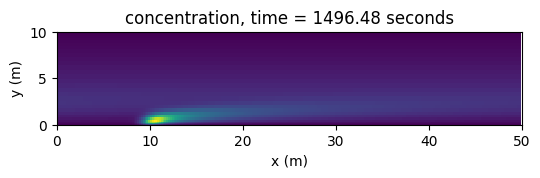

In [109]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
a) In the boxes below, plot the pollution concentration at a few points as a function of time.

b) Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters.

c) Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

a) Initially I tried plotting concentration for the middle of the river, but there was no major difference in concentration along the length, which is also visible in the colour plots above. So instead I considered a distance 0.6 m across the river, starting from the bank on which the pollutant is being released.

In [103]:
c_save[:, 20, 20]
print(X[5,200])
print(Y[5,200])


38.96484375
0.5957052421907116


Text(0.5, 1.0, 'x = 39.0 m, y = 0.6 m (further downstream)')

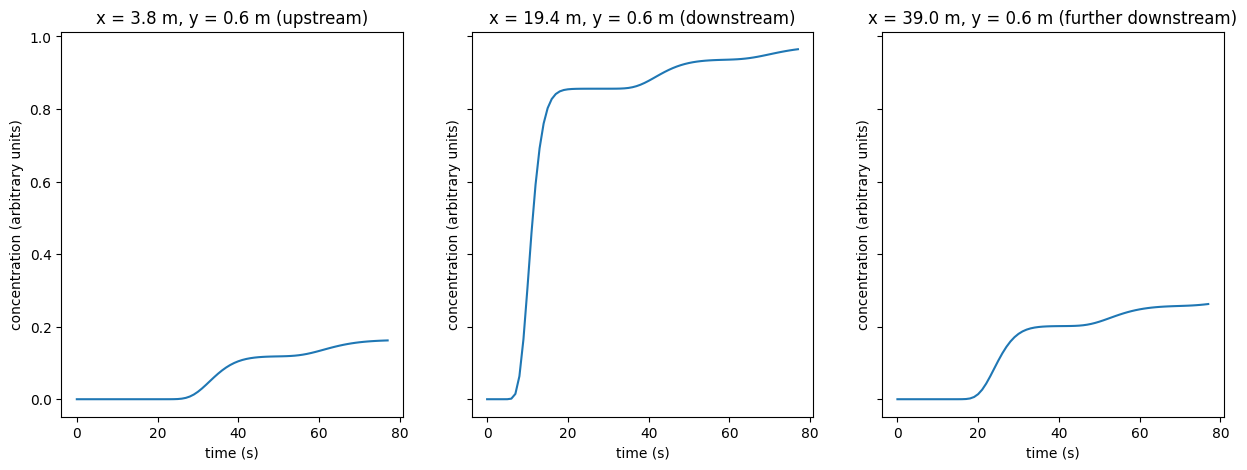

In [107]:
c_save.shape
# 256 x points
# 32 y points
# so 78 timesteps

fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)

for i in range(0,3):
  ax[i].set_xlabel('time (s)')
  ax[i].set_ylabel('concentration (arbitrary units)')

ax[0].plot(c_save[:, 20, 5].T)
ax[0].set_title('x = 3.8 m, y = 0.6 m (upstream)')

ax[1].plot(c_save[:, 100, 5].T)
ax[1].set_title('x = 19.4 m, y = 0.6 m (downstream)')

ax[2].plot(c_save[:, 200, 5].T)
ax[2].set_title('x = 39.0 m, y = 0.6 m (further downstream)')

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.